In [3]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt

In [7]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']

# Extract EEG data
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)

print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)

EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)


In [ ]:
# 2. Load channel information from the file
channel_names = []
channel_coords = []
with open('eloc64C2.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        parts = line.split()
        # Convert polar coordinates to Cartesian coordinates
        theta = float(parts[1]) * np.pi / 180  # Convert to radians
        rho = float(parts[2])
        x = rho * np.cos(theta)
        y = rho * np.sin(theta)
        channel_names.append(parts[3].replace('.', ''))  # Remove dots from channel names
        channel_coords.append((x, y))
        channel_coords_3d = [(x, y, 0) for x, y in channel_coords]  # Add a z-coordinate

# Create a custom montage with 3D coordinates
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(channel_names, channel_coords_3d)),
                                        coord_frame='head', nasion=None, lpa=None, rpa=None)
# Create Info object and set montage
# The info variable typically contains metadata about the EEG data, such as the sampling rate, channel names, channel types, etc
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)

In [10]:
# a.1. Extract Epochs from 0 to 800 ms
# Given a sampling rate of 256 Hz, the time interval between two consecutive samples is 1/256 = 3.90625 ms. (I consider 4ms for each sample point)
# Thus, 0 ms corresponds to the sample point at index 256, 
# and 800 ms corresponds to the sample point at index (800 / 3.90625) = 256+204.8=460.8, which can be rounded to 461.

eeg_data_epoch= eeg_data[:, 256:462, :] # eeg_data_epoch.shape: (64, 206, 99), 256:462:
#This indexes elements from the 256th to the 461st along the second dimension(since Python indexing is 0-based and the stop value in a slice is exclusive).
eeg_data_epoch_20= eeg_data[:, 251:467, :] # eeg_data_epoch_20.shape:(64, 216, 99)
print('eeg_data_epoch.shape:', eeg_data_epoch.shape, 'eeg_data_epoch_20.shape', eeg_data_epoch_20.shape )

eeg_data_epoch.shape: (64, 206, 99) eeg_data_epoch_20.shape (64, 216, 99)


In [ ]:
# Compute the ERP at each electrode by averaging across all trials
ERP = np.mean(eeg_data_epoch, axis=2) # shape: (64, 206)
ERP_20 = np.mean(eeg_data_epoch_20, axis=2) # shape: (64, 216)

# Create an evoked object
# The evoked object is an instance of the EvokedArray class in MNE, which is useful for visualization and further processing in the MNE ecosystem.
#ERP: It is a 2D numpy array that contains the event-related potential values. This is a simple numeric representation with dimensions corresponding to channels and time points.
#evoked: It is an object of type EvokedArray that wraps around the ERP numpy array. It integrates the numeric ERP data with metadata (info)
#and provides various methods and attributes for easier visualization and analysis of the data in the context of the MNE-Python library. 
evoked = mne.EvokedArray(ERP, info)
evoked_20 = mne.EvokedArray(ERP_20, info)

# a.2. Plot the topographical map
#The evoked.plot_topomap() function from the MNE-Python library is used to plot topographical maps of EEG data, 
# giving a spatial representation of voltage (or other measures) across the scalp at specific points in time.
evoked.plot_topomap(times=np.linspace(0, .8, 9), nrows=3, ncols=3, size=1, time_unit='s')
plt.show()

# Plot the sensor locations
#When you're plotting EEG channels with plot_sensors, MNE sometimes creates two plots: one for a top-down view and another for a side view,
# especially when 3D channel locations (with both horizontal and vertical coordinates) are present.
#You can suppress the side view by setting the proj argument to True:
evoked.plot_sensors(kind='topomap', show_names=True, ch_type='eeg')

C:\Users\tnlab\AppData\Local\Temp\ipykernel_21968\2701155620.py:20: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


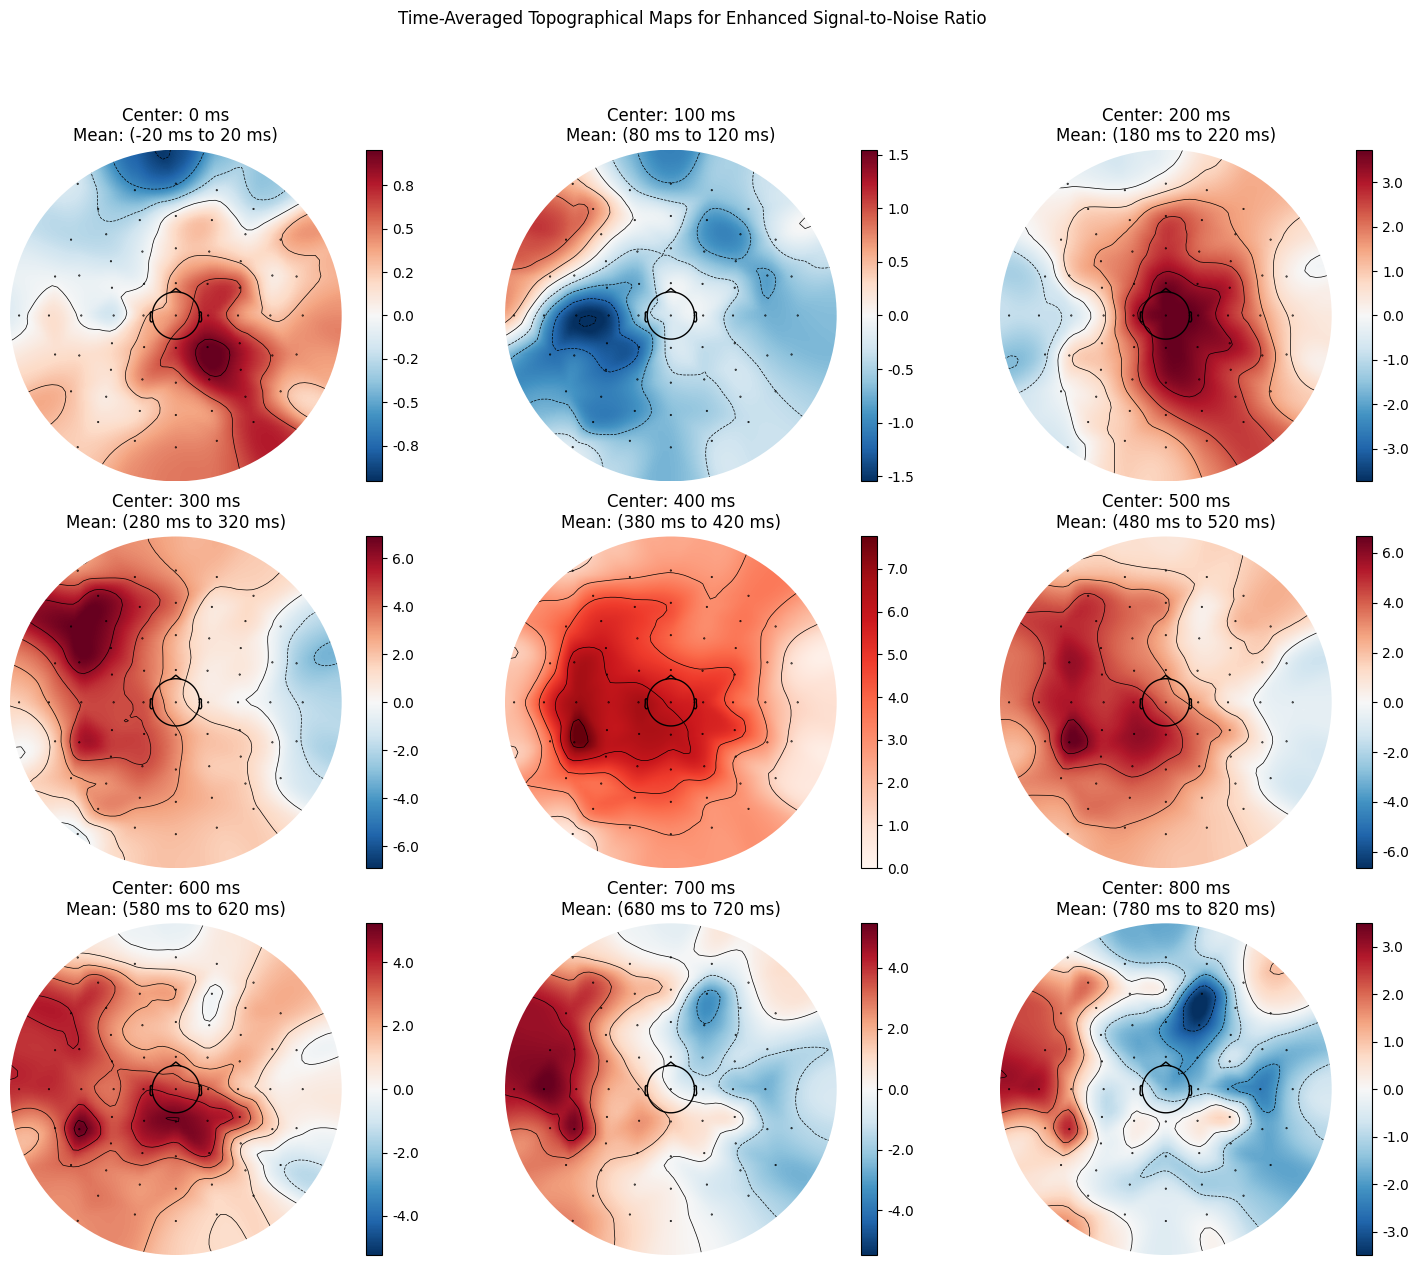

In [60]:
# a. Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio

# Close any existing plots
plt.close('all')

# Define center times 
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms

# Create a figure to hold the subplots
fig, axs = plt.subplots(3, 3, figsize=(15,12))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.05)

# Now plot the topomaps
for idx, center_time in enumerate(center_times):
    # Define the time window around the center time: 20 ms before and after
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    
    # Crop the data around this time window and compute the average
    avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    
    # Create a subplot for this topographical map
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data, evoked_20.info, axes=ax, show=False)

    # Manually add colorbar to each plot
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical')
    
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")

plt.tight_layout()
plt.show()


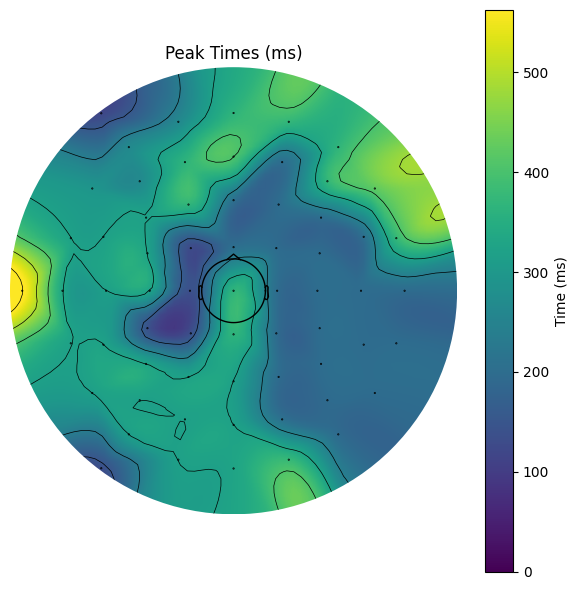

In [61]:
# b. 
times = evoked.times

# Convert the time window in milliseconds to time indices
start_idx = np.where(times >= 0.1)[0][0]
end_idx = np.where(times <= 0.8)[0][-1]

# ERP data
ERP = evoked.data

# List to store peak times for each channel
peak_times = []

for channel_data in ERP:
    # Extract the data of this electrode between 100 and 800 ms
    channel_data_window = channel_data[start_idx:end_idx + 1]
    
    # Get index of max value in this window
    peak_time_idx = np.argmax(channel_data_window)
    
    # Convert index to time and append to peak_times list
    peak_times.append(times[start_idx + peak_time_idx] * 1000)  # in ms

# Now let's plot this using a topographical map
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im, _ = mne.viz.plot_topomap(peak_times, evoked.info, cmap='viridis', axes=ax, show=False)
ax.set_title("Peak Times (ms)")
plt.colorbar(im, ax=ax, label="Time (ms)")
plt.tight_layout()
plt.show()



In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

# Use StringIO to read the data from the string
from io import StringIO
eloc64_fileTable = pd.read_csv(StringIO(data), delim_whitespace=True, skiprows=1, header=None, names=['id', 'theta', 'radius', 'label'])


# 2. Convert polar to Cartesian coordinates
theta = eloc64_fileTable['theta'].values.astype(float)
radius = eloc64_fileTable['radius'].values.astype(float)
X, Y = radius * np.cos(np.deg2rad(theta)), radius * np.sin(np.deg2rad(theta))



# 3. Compute pairwise Euclidean distances between all channels
eucdist = np.sqrt((X[:, None] - X)**2 + (Y[:, None] - Y)**2)

# 4. Create a filtered distance matrix
lo_width, hi_width = 0.18, 0.28
eucdist_filtered = np.where((eucdist > lo_width) & (eucdist < hi_width), eucdist, 0)

# 5. Compute weights
weights = np.zeros_like(eucdist_filtered)
for chn1 in range(len(X)):
    for chn2 in range(len(X)):
        if eucdist_filtered[chn1, chn2] != 0:
            weights[chn1, chn2] = (1 / eucdist_filtered[chn1, chn2]) / np.sum(1 / eucdist_filtered[chn1, :])

# 6. Plot the filtered distances for each channel using MNE's topoplot
info = mne.create_info(ch_names=list(eloc64_fileTable['label']), sfreq=250, ch_types='eeg', montage='standard_1020')
plt.figure(figsize=(16, 16))
for chn1 in range(len(X)):
    ax = plt.subplot(8, 8, chn1+1)
    mne.viz.plot_topomap(eucdist_filtered[chn1, :], info, cmap='jet', axes=ax, show=False)
    ax.set_title(f"Channel {eloc64_fileTable['label'].iloc[chn1]}")

plt.tight_layout()
plt.show()

print("It is done.")


ValueError: could not convert string to float: 'eloc64c2.txt'